## Setup and Imports

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model #For GARCH models
from statsmodels.tsa.ar_model import AutoReg #For AR Model (Naive Baseline)
import warnings
warnings.filterwarnings('ignore')


plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

print("Libraries loaded successfully")

Libraries loaded successfully


## 1. Data Simulation

We generate synthetic spacecraft telemetry using an AR(1)-GARCH(1,1) process:

**Mean equation (AR):**
$$y_t = \mu + \phi(y_{t-1} - \mu) + \varepsilon_t$$

**Variance equation (GARCH):**
$$\varepsilon_t = \sigma_t z_t, \quad z_t \sim N(0,1)$$
$$\sigma_t^2 = \omega + \alpha \varepsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

**Parameters:**
- $\mu = 100$ 
- $\phi = 0.8$ 
- $\omega = 0.5$, $\alpha = 0.15$, $\beta = 0.80$ 
- $\alpha + \beta = 0.95 < 1$ 

In [24]:
# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
T = 1000          # Number of time steps
phi = 0.8         # AR(1) coefficient (autocorrelation)
mu = 100          # Long-run mean
omega = 0.5       # GARCH baseline variance parameter
alpha = 0.15      # GARCH shock sensitivity (ARCH term)
beta = 0.80       # GARCH volatility persistence (GARCH term)

# Verify stability condition
print(f"α + β = {alpha + beta:.2f}")
print(f"Stability condition (α + β < 1): {'SATISFIED' if alpha + beta < 1 else 'VIOLATED'}")

# Calculate unconditional variance
sigma_bar_sq = omega / (1 - alpha - beta)
sigma_bar = np.sqrt(sigma_bar_sq)
print(f"\nUnconditional variance σ̄² = {sigma_bar_sq:.2f}")
print(f"Unconditional std dev σ̄ = {sigma_bar:.2f}")
print(f"Relative volatility: {sigma_bar/mu*100:.1f}%")

α + β = 0.95
Stability condition (α + β < 1): SATISFIED

Unconditional variance σ̄² = 10.00
Unconditional std dev σ̄ = 3.16
Relative volatility: 3.2%


### Generate AR(1)-GARCH(1,1) Time Series

In [25]:
# Initialize arrays to store the time series
y = np.zeros(T)              # The actual time series values
sigma_sq = np.zeros(T)       # Conditional variance at each time
epsilon = np.zeros(T)        # The shocks/errors at each time

# Set initial conditions
y[0] = mu                                    # Start at the mean
sigma_sq[0] = omega / (1 - alpha - beta)     # Start at unconditional variance

# Generate the time series
for t in range(1, 1000):
    # Step 1: Update conditional variance (GARCH equation)
    sigma_sq[t] = omega + alpha * epsilon[t-1]**2 + beta * sigma_sq[t-1]
    
    # Step 2: Generate standardized shock
    z_t = np.random.randn()  # Draw from N(0,1)
    
    # Step 3: Scale shock by time-varying volatility
    epsilon[t] = np.sqrt(sigma_sq[t]) * z_t
    
    # Step 4: Generate observation (AR equation)
    y[t] = mu + phi * (y[t-1] - mu) + epsilon[t]

print(f"Generated {T} observations")
print(f"\nTime series statistics:")
print(f"  Mean: {np.mean(y):.2f} (target: {mu})")
print(f"  Std Dev: {np.std(y):.2f} (target: ~{sigma_bar:.2f})")
print(f"  Min: {np.min(y):.2f}")
print(f"  Max: {np.max(y):.2f}")
print(f"\nVolatility statistics:")
print(f"  Mean σ: {np.mean(np.sqrt(sigma_sq)):.2f} (target: {sigma_bar:.2f})")
print(f"  Min σ: {np.min(np.sqrt(sigma_sq)):.2f}")
print(f"  Max σ: {np.max(np.sqrt(sigma_sq)):.2f}")

Generated 1000 observations

Time series statistics:
  Mean: 100.09 (target: 100)
  Std Dev: 4.49 (target: ~3.16)
  Min: 85.91
  Max: 114.08

Volatility statistics:
  Mean σ: 2.80 (target: 3.16)
  Min σ: 1.78
  Max σ: 5.18


### Visualize Simulated Data

We should see:
1. **Top plot:** Time series with visible "calm" and "volatile" periods
2. **Bottom plot:** Time-varying volatility (σ_t) showing clusters

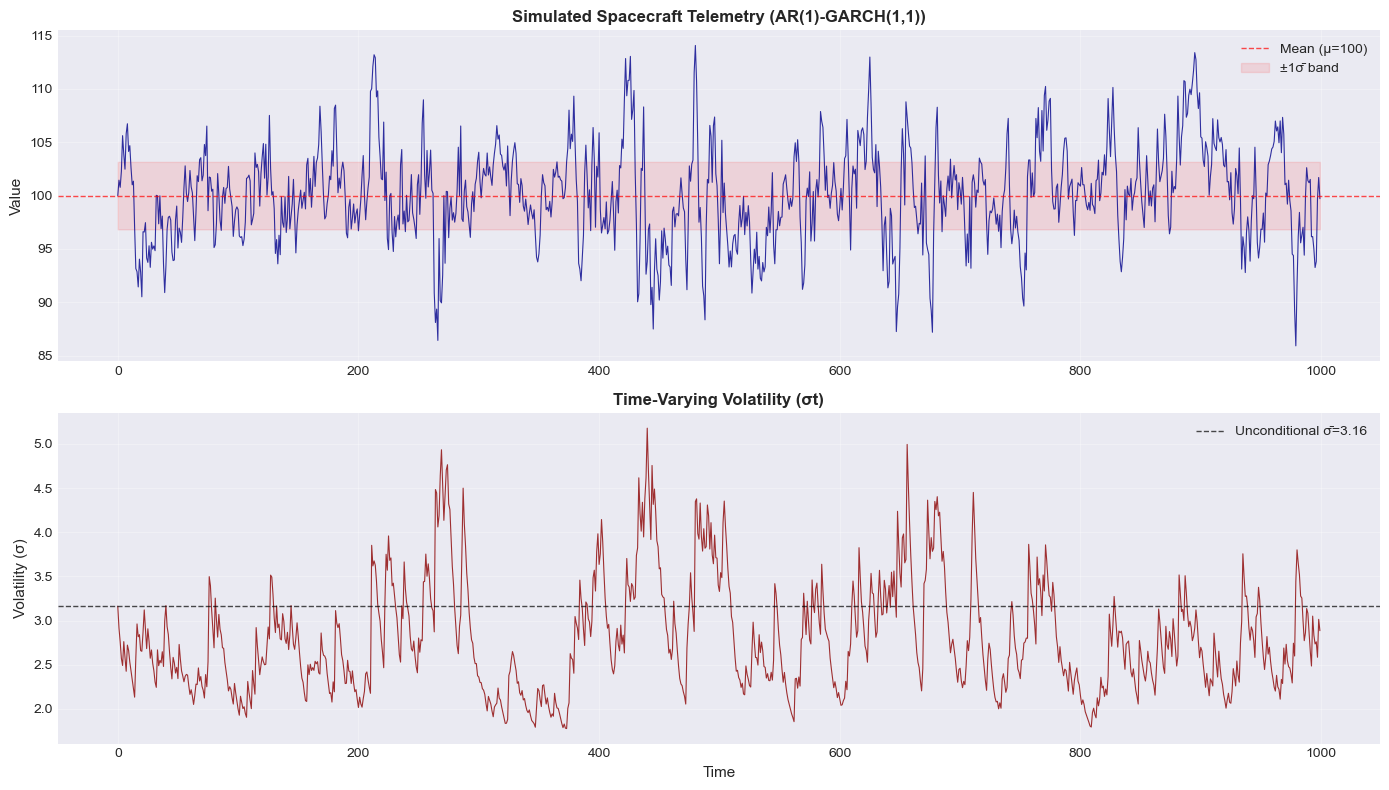

✓ Plots generated successfully


In [27]:
# Create DataFrame for easier manipulation
df = pd.DataFrame({
    'time': range(T),
    'y': y,
    'sigma': np.sqrt(sigma_sq),
    'epsilon': epsilon
})

# Create visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Top: Time series
axes[0].plot(df['time'], df['y'], linewidth=0.8, color='darkblue', alpha=0.8)
axes[0].axhline(y=mu, color='red', linestyle='--', linewidth=1, alpha=0.7, label=f'Mean (μ={mu})')
axes[0].fill_between(df['time'], mu - sigma_bar, mu + sigma_bar, 
                       color='red', alpha=0.1, label=f'±1σ̄ band')
axes[0].set_title('Simulated Spacecraft Telemetry (AR(1)-GARCH(1,1))', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Value', fontsize=11)
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Bottom: Time-varying volatility
axes[1].plot(df['time'], df['sigma'], linewidth=0.8, color='darkred', alpha=0.8)
axes[1].axhline(y=sigma_bar, color='black', linestyle='--', linewidth=1, alpha=0.7, 
                 label=f'Unconditional σ̄={sigma_bar:.2f}')
axes[1].set_title('Time-Varying Volatility (σt)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Time', fontsize=11)
axes[1].set_ylabel('Volatility (σ)', fontsize=11)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Plots generated successfully")

## 2. Train/Test Split and Regime Definition

We split data into:
- **Training set:** First 800 observations (80%)
- **Test set:** Last 200 observations (20%)

We define volatility regimes based on the median of true σ:
- **Low volatility:** σ < median
- **High volatility:** σ ≥ median

This allows us to evaluate whether prediction intervals maintain calibration across operational contexts.

In [ ]:
# Train/test split
train_size = 800
train_df = df.iloc[:train_size].copy()
test_df = df.iloc[train_size:].copy()

print(f"Training data: {len(train_df)} observations (time 0-{train_size-1})")
print(f"Test data: {len(test_df)} observations (time {train_size}-{T-1})")

# Define volatility regimes based on median
median_sigma = df['sigma'].median()

df['regime'] = 'low_vol'
df.loc[df['sigma'] > median_sigma, 'regime'] = 'high_vol'

# Update test_df with regime labels
test_df = df.iloc[train_size:].copy()

print(f"\nMedian volatility σ̃ = {median_sigma:.2f}")
print(f"\nTest set regime distribution:")
print(test_df['regime'].value_counts())
print(f"\nAverage σ in each regime (test set):")
print(test_df.groupby('regime')['sigma'].mean().round(2))